In [1]:
!pip install texttable
!pip install texttable rasterio

import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import match_histograms
import time
import texttable as tt
import rasterio
from rasterio.plot import reshape_as_raster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 48.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path configuration
# Path configuration for Google Drive
out_dir = '/content/drive/My Drive/pansharp_with_new_high'
filename_b2 = os.path.join(out_dir, 'B2.tif')
filename_b3 = os.path.join(out_dir, 'B3.tif')
filename_b4 = os.path.join(out_dir, 'B4.tif')
filename_pan = os.path.join(out_dir, 'pla.tif')


# Multiespectral bands
r_img_B2 = rasterio.open(filename_b2)
r_img_B3 = rasterio.open(filename_b3)
r_img_B4 = rasterio.open(filename_b4)
img_B2 = r_img_B2.read(1)
img_B3 = r_img_B3.read(1)
img_B4 = r_img_B4.read(1)

# Panchromatic band
r_img_pan = rasterio.open(filename_pan)
img_pan = r_img_pan.read(1)

# Images metadata
print('Sentinel-2 -> band 2 shape:',img_B2.shape, '| Range (min, max): (', np.amin(img_B2), ',', np.amax(img_B2), ')')
print('Sentinel-2 -> band 3 shape:',img_B3.shape, '| Range (min, max): (', np.amin(img_B3), ',', np.amax(img_B3), ')')
print('Sentinel-2 -> band 4 shape:',img_B4.shape, '| Range (min, max): (', np.amin(img_B4), ',', np.amax(img_B4), ')')
print('PlanetScope -> panchromatic shape:',img_pan.shape, '| Range (min, max): (', np.amin(img_pan), ',', np.amax(img_pan), ')')

# Concatenate the bands of the multiespectral image into a single numpy array
R = np.expand_dims(img_B4, axis=2)
G = np.expand_dims(img_B3, axis=2)
B = np.expand_dims(img_B2, axis=2)

img_xs = np.concatenate((R,G), axis=2)
img_xs = np.concatenate((img_xs,B), axis=2)
print('Multiespectral image shape:', img_xs.shape)

Sentinel-2 -> band 2 shape: (437, 730) | Range (min, max): ( 0 , 4072 )
Sentinel-2 -> band 3 shape: (437, 730) | Range (min, max): ( 0 , 4492 )
Sentinel-2 -> band 4 shape: (437, 730) | Range (min, max): ( 0 , 4872 )
PlanetScope -> panchromatic shape: (437, 730) | Range (min, max): ( 0 , 1900 )
Multiespectral image shape: (437, 730, 3)


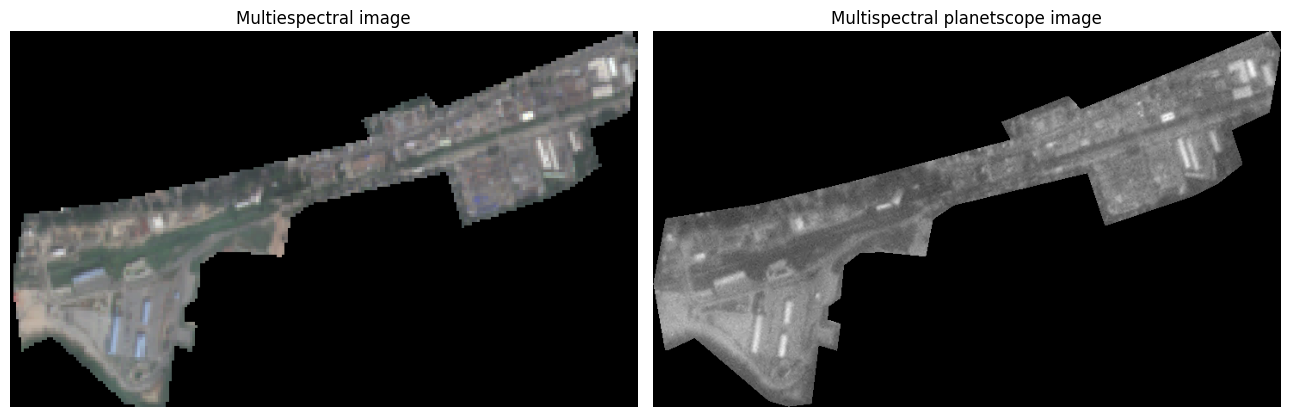

In [5]:
# Multiespectral image normalization
R = (((R-np.amin(R))/(np.amax(R)-np.amin(R)))*255).astype(int)
G = (((G-np.amin(G))/(np.amax(G)-np.amin(G)))*255).astype(int)
B = (((B-np.amin(B))/(np.amax(B)-np.amin(B)))*255).astype(int)
xs = np.concatenate((R,G), axis=2)
xs = np.concatenate((xs,B), axis=2)

# Panchromatic image normalization
pan = (((img_pan-np.amin(img_pan))/(np.amax(img_pan)-np.amin(img_pan)))*255).astype(int)

# Container creation, to fit the plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

# Add the multiespectral image to the container
ax0.imshow(xs)
ax0.set_title("Multiespectral image")
ax0.axis('off')

# Add the panchromatic image to the container
ax1.imshow(pan, 'gray')
ax1.set_title("Multispectral planetscope image")
ax1.axis('off')

plt.tight_layout()

In [6]:
#degradation filter


# Base filter used to degradate the images
base_filter = 1/256 * np.array([[1, 4, 6, 4 ,1],
[4, 16, 24, 16, 4],
[6, 24, 36, 24, 6],
[4, 16, 24, 16, 4],
[1, 4, 6, 4 ,1]])

def obtain_filter(n=0,base_filter=base_filter):
    filter = []
    for row in base_filter:
        filter.append(put_n_zeros(row, n))
    return put_n_rows_of_zeros(filter,n)

'''
    This method adds n zeros between each element of the array
'''
def put_n_zeros(row, n):
    result = [row[0]]
    for i in range(1,len(row)):
        result += [0]*n + [row[i]]
    return result

'''
    This method adds n rows of zeros between each element of the matrix
'''
def put_n_rows_of_zeros(matrix, n):
    zeros = np.zeros((n,len(matrix[0])))
    result = [matrix[0]]
    for i in range(1,len(matrix)):
        result = np.concatenate((result, zeros, [matrix[i]]))
    return result

In [7]:
#standard wavelet à trous fusion

'''
Input:
    arr1 -> Multispectral band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    coefs -> A list containing the wavelet coefficients of each degradation
    current_degradation -> Degradated band after applying levels - init_level filters
'''
def twa(arr1, levels, init_level=0):
    # Init variables
    previous_degradation = np.array(arr1)
    current_degradation = []
    coefs = np.empty([arr1.shape[0],arr1.shape[1],0])
    # Apply levels - init_level degradations
    for level in range(init_level, levels):
        # Obtain the filter for each level
        a_trous_filter = obtain_filter(level)
        # Convolution between the image and the filter
        current_degradation = signal.convolve2d(previous_degradation, a_trous_filter, mode='same')
        # Obtain the wavelet coefficients
        current_coef = previous_degradation-current_degradation
        current_coef = np.expand_dims(current_coef, axis=2)
        coefs = np.append(coefs, current_coef, axis=2)
        previous_degradation = current_degradation
    return coefs, current_degradation

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_twa_multiband(xs, pan, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_image = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_twa_single_band(xs[:,:,nBand], pan, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_image = np.append(fused_image, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        fused_image = None
    return fused_image

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_twa_single_band(xs, pan, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    fused_band = f_xs + coef_pan
    return fused_band

In [8]:
#weighted wavelet à trous fusion

# The original wavelet a trous algorithm strategy does not consider spectral differences between bands and cannot control the inherent
#trade-off between spatial-spectral quality in the fused image.

# Lillo-Saavedra and Gonzalo (2006) (https://www.tandfonline.com/doi/abs/10.1080/01431160500462188) proposed a modification of the à trous algorithm, establishing a mechanism that controls this trade-off by introducing a wavelet coefficient weighting factor (
# ) for the panchromatic wavelet coefficients.

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    alpha -> Weight of the spatial resolution for each band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_wtwa_multiband(xs, pan, alpha, levels, init_level=0):
    s_time = time.time()
    # If we receive a int instead of a vector of n-bands weights, we apply the same weight to each band
    if type(alpha) in (float,int):
        alpha = [alpha]*xs.shape[2]
    # Initialize image
    fused_img = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_wtwa_single_band(xs[:,:,nBand], pan, alpha[nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    alpha -> Weight of the spatial resolution
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_wtwa_single_band(xs, pan, alpha, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving " + str(alpha) + " to the weight of the spatial resolution")
    fused_band = f_xs + alpha*coef_pan
    return fused_band

In [9]:
# weighted by local entropy maps wavelet à trous fusion
# Despite the previously mentioned advantage of the weighted wavelet à trous fusion algorithm, the method is not capable of discriminating
# between different land covers present in images. In that sense, the same value of
#  is used to weigh the information coming from the panchromatic wavelet coefficients for each spectral band.
#  This is the main cause of the artifacts in the fused images. To overcome this problem, (M. Lillo et al., 2011)
#  (https://www.sciencedirect.com/science/article/pii/S030324341100002X) proposed a new version of this algorithm.

'''
Input:
    xs -> Multispectral image
    pan -> Panchromatic image
    radius -> Neighborhood radius
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_ftwa_multiband(xs, pan, radius, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_img = np.empty([xs.shape[0], xs.shape[1], 0])
    # If the panchromatic image has more than one band, we use the first
    if pan.ndim > 2:
        pan = pan[:,:,0]
    # If the multispectral image has 3 bands or more, we start the fusion
    if xs.ndim > 2:
        for nBand in range(xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_ftwa_single_band(xs[:,:,nBand], pan, radius, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image
    radius -> Radius of the neighborhood
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_ftwa_single_band(xs, pan, radius, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving with " + str(radius) + " as the radius of the entropy")
    fused_band = f_xs + applyEntropy(xs, radius)*coef_pan
    return fused_band

def applyEntropy(xs, radius):
    img = entropy(xs, disk(radius))
    # Normalize values to 1 as max value
    img = img/np.amax(img)
    return img

In [10]:
# TWAT fusion with 5 cicles
img_fus = fusion_twa_multiband(img_xs, img_pan, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fused band 0 of the multispectral image
---- 1.3078088760375977 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fused band 1 of the multispectral image
---- 2.831709623336792 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fused band 2 of the multispectral image
---- 4.065744161605835 seconds ------
---------------------------------------------------


In [11]:
# Weighted TWAT fusion with 5 cicles (Weight range -> [0,2])
img_fus = fusion_wtwa_multiband(img_xs, img_pan, 1.5, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 0 of the multispectral image
---- 2.01141095161438 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 1 of the multispectral image
---- 6.65511155128479 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 2 of the multispectral image
---- 8.753124713897705 seconds ------
---------------------------------------------------


In [12]:
# FractalxTWAT fusion with 5 cicles (the third parameter is the entropy radius)
img_fus = fusion_ftwa_multiband(img_xs, img_pan, 10, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy


/usr/local/lib/python3.10/dist-packages/skimage/filters/rank/generic.py:262: UserWarning: Bad rank filter performance is expected due to a large number of bins (4873), equivalent to an approximate bitdepth of 12.3.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


Fused band 0 of the multispectral image
---- 3.6519224643707275 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy


/usr/local/lib/python3.10/dist-packages/skimage/filters/rank/generic.py:262: UserWarning: Bad rank filter performance is expected due to a large number of bins (4493), equivalent to an approximate bitdepth of 12.1.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


Fused band 1 of the multispectral image
---- 7.296705484390259 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy


/usr/local/lib/python3.10/dist-packages/skimage/filters/rank/generic.py:262: UserWarning: Bad rank filter performance is expected due to a large number of bins (4073), equivalent to an approximate bitdepth of 12.0.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


Fused band 2 of the multispectral image
---- 10.680253028869629 seconds ------
---------------------------------------------------


In [13]:
img_fus[:,:,0] = ((img_fus[:,:,0]-np.amin(img_fus[:,:,0]))/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amax(img_xs[:,:,0]) + ((np.amax(img_fus[:,:,0]) - img_fus[:,:,0])/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amin(img_xs[:,:,0])
img_fus[:,:,1] = ((img_fus[:,:,1]-np.amin(img_fus[:,:,1]))/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amax(img_xs[:,:,1]) + ((np.amax(img_fus[:,:,1]) - img_fus[:,:,1])/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amin(img_xs[:,:,1])
img_fus[:,:,2] = ((img_fus[:,:,2]-np.amin(img_fus[:,:,2]))/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amax(img_xs[:,:,2]) + ((np.amax(img_fus[:,:,2]) - img_fus[:,:,2])/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amin(img_xs[:,:,2])
print('Completed normalization to the multispectral image values')

Completed normalization to the multispectral image values


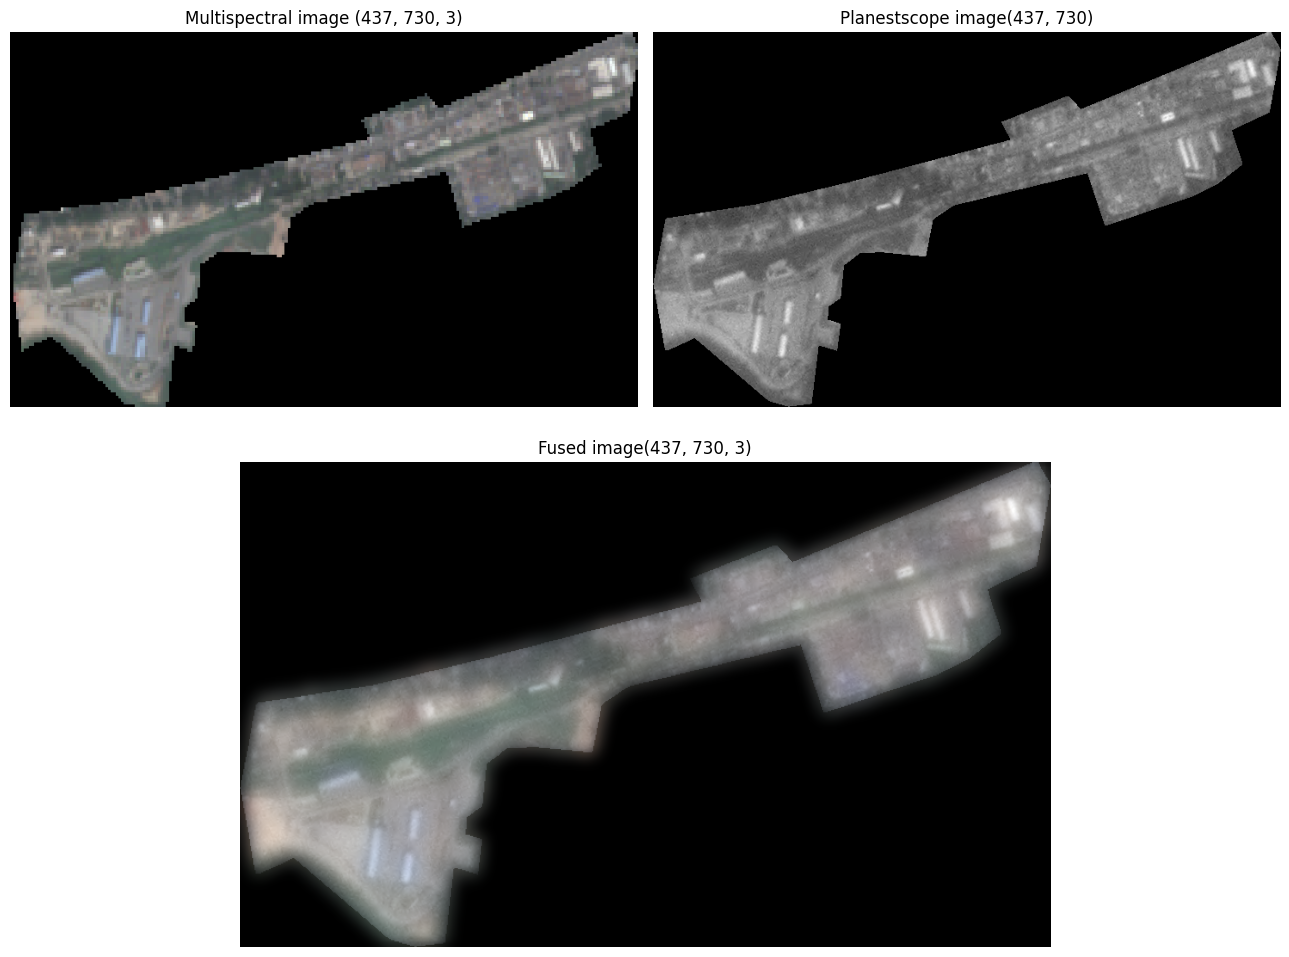

In [15]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

# Container creation, to fit the plots, with gridspec layout from matplotlib
fig = plt.figure(figsize=(13, 10))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Add the multispectral image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(xs)
ax0.set_title("Multispectral image " + str(img_xs.shape))
ax0.axis('off')

# Add the panchromatic image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(pan, 'gray')
ax1.set_title("Planestscope image"  + str(img_pan.shape))
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[1,:])
ax2.imshow(vis_fus)
ax2.set_title("Fused image" + str(img_fus.shape))
ax2.axis('off')

plt.tight_layout()